In [6]:
import pandas as pd
import os
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import numpy as np
from geopy import distance

Task 1) Import all csv files

In [ ]:
csv_file_name = './data/sensor_positions.csv'
columns = ['sensor_name', 'latitude', 'longitude', 'region']
sensor_df = pd.DataFrame(columns=columns, index=[0])

with open('./data/' + csv_file_name, 'r') as read_obj:
    csv_reader = reader(read_obj)
    for row in csv_reader:
        data = {columns[0]: row[1], columns[1]: float(row[0].split(' ')[0].replace('(', '')), columns[2]: float(row[0].split(' ')[1].replace(')', '')), columns[3] : ''}
        data_df = pd.DataFrame(data, columns=columns, index=[0])
        sensor_df = pd.concat([sensor_df, data_df])

sensor_df = sensor_df.dropna()

In [7]:
dir_path = './data'
csv_file_names = []

for path in os.listdir(dir_path):
    if os.path.isfile(os.path.join(dir_path, path)):
        if path.find('.csv') != -1:
            csv_file_names.append(path)

Append all csv files to a list of dataframes and add the id of the sensor to distinguish them later on

In [8]:
list_df = []
sensor_names = []

for filename in csv_file_names:
    df = pd.read_csv('./data/' + filename, index_col=None, header=0)
    df['Time'] = df.apply(lambda row: datetime.strptime(row['Time'], '%Y-%m-%d %H:%M:%S'), axis=1)
    sensor_names.append(filename[12:16]);
    list_df.append(df);

list_len = [len(df) for df in list_df];

In [9]:
start_time = datetime.strptime('2022.02.20 00:00:00', '%Y.%m.%d %H:%M:%S')
end_time = datetime.strptime('2022.03.05 00:00:00', '%Y.%m.%d %H:%M:%S')
index = pd.date_range(start_time, end_time, freq='1min')

list_df_incomplete = []


for df in list_df:
    # get rid of redundant datapoints
    df = df[df.Time >= start_time]
    df = df[df.Time <= end_time]
    df.drop_duplicates(subset='Time', keep='first', inplace=True)
    
    # index data by Time
    df.index = pd.to_datetime(df['Time'])
    df.drop(columns=['Time'], inplace=True)
    df = df.reindex(index)
    
    list_df_incomplete.append(df)


Remove all measurements with a timestamp not inbetween 2022.02.20 00:00:00 to 2022.03.04 24:00:00, set the timestamp as index of the dataframe, and add the start and end timestamp of the measurement period to the dataframe it doesn't exist

Convert the time series to equally-spaced data with one minute time intervals and interpolate missing data with the "nearest" interpolant. Therefore, let's insert all missing timestamps first, join existing measurements and finally interpolate missing values.

12658
0


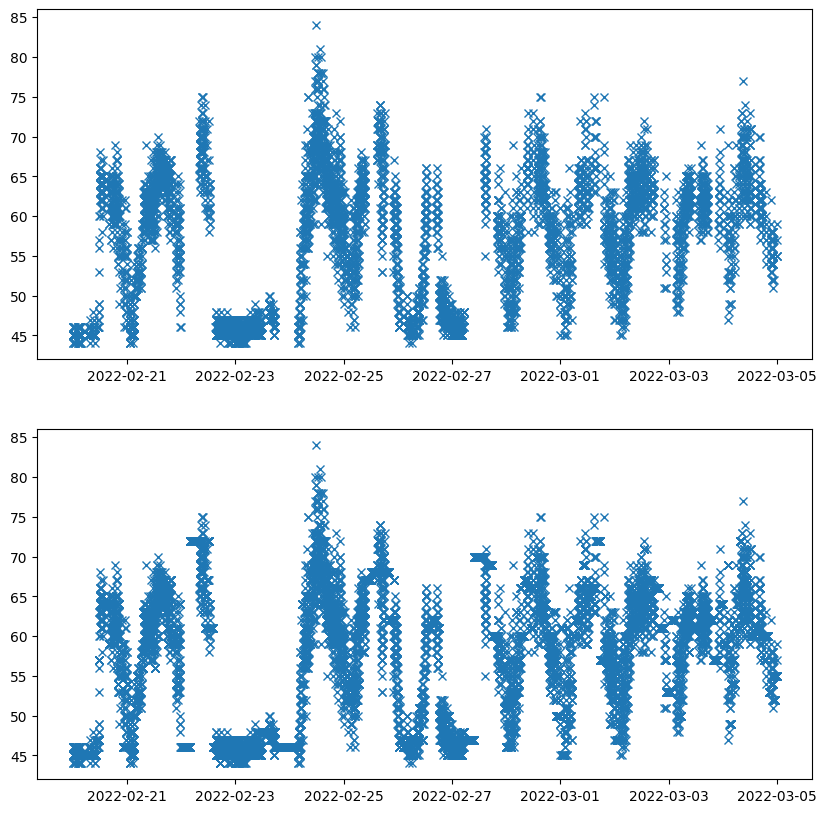

In [26]:
#interpolate data using 'nearest' method
list_df_other = []
list_df_nearest = []

for df in list_df:
    df = df.interpolate(method='nearest')
    list_df_nearest.append(df)

Task 2) Interpolate missing data

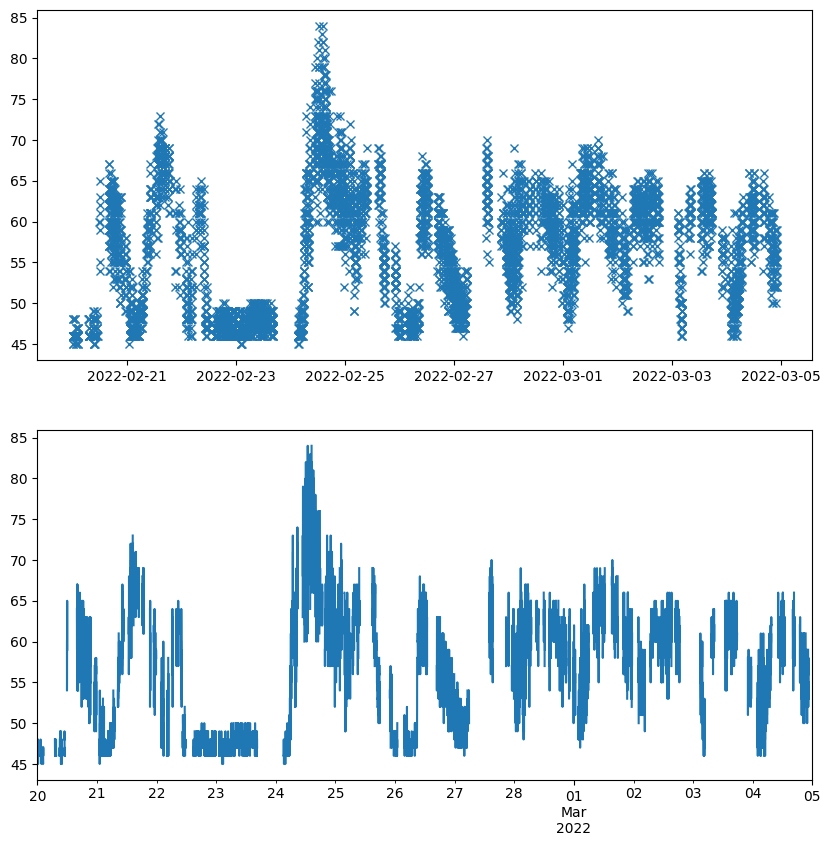

In [12]:
import datetime



list_df_inter = []
figure, axis = plt.subplots(2, 1, figsize=(10, 10))
ts = list_ts_incomplete[0].copy()
ts.interpolate(method='nearest', inplace=True)

list_ts_incomplete[0].plot()
axis[0].plot(list_ts_incomplete[0].index,list_ts_incomplete[0].values, 'x')
axis[1].plot(ts.index,ts.values, 'x')




Resample to eliminate rows not corresponding to our sampling frequency

In [19]:
ts.isna().sum()
ts2= ts.interpolate(method='nearest')
ts2.isna().sum()

96

Task 3) Construct Lag plots for lags 1, 10, 60 and 720 for one sensor (for all sensors it would be 48 plots)

In [ ]:
lags = [1, 10, 60, 720]
figure, axis = plt.subplots(4, 1, figsize=(10, 10))

for i, lag in enumerate(lags):
    pd.plotting.lag_plot(list_df_inter[0]['dt_sound_level_dB_y'], lag=lag, ax=axis[i])
    axis[i].set_xlabel('dB(t)')
    axis[i].set_ylabel(f'dB(t + {lag} minutes)')

plt.tight_layout()
plt.show()

Compute R2 values for each lag plot

In [ ]:
for lag in lags:
    for i, df in enumerate(list_df_inter):
        y_pred = df['dt_sound_level_dB_y'].iloc[lag:]
        y_true = df['dt_sound_level_dB_y'].iloc[:-lag]
        r2 = r2_score(y_true, y_pred)
        print(f'R2 coefficient for sensor {sensor_names[i]} and lag {lag}: {r2}')

    print('-----------')

Task 4) Interpretation of R2 coefficients:
It appears that there is a strong positive correlation between the sound level measured by each sensor and the lagged sound level at a lag of 1 minute, with R2 values ranging sligthly below 1. As the lag increases, the correlation becomes weaker, with R2 values ranging around 0.5 for a lag of 60 minutes. For a lag of 720 minutes, there is a negative correlation, which indicate that the model doesn't follow the trend of data at all (switched to non-deterministic).

Task 5) Randomly resample the data from three stations using a uniform distribution with sample sizes of 1%, 5%, 10%, 50% and 90%. Plot the three statistical parameters mean, median and standard deviation as a function of the sample percentage for each site.
Stations: 206D, 201D (next to each other), 2004 (further away)

In [ ]:
sample_sizes = [0.01, 0.05, 0.1, 0.5, 0.9]
stats = ['mean', 'median', 'std']

data = [list_df_inter[4], list_df_inter[3], list_df_inter[0]]
sensor_names = ['206D', '201D', '2004']
means = []
medians = []
stds = []

for df in data:
    mean_list = []
    median_list = []
    std_list = []

    for size in sample_sizes:
        sample_size = int(size * len(df))
        sample = df.sample(n=sample_size, replace=False)
        mean_list.append(np.mean(sample['dt_sound_level_dB_y']))
        median_list.append(np.median(sample['dt_sound_level_dB_y']))
        std_list.append(np.std(sample['dt_sound_level_dB_y']))

    means.append(mean_list)
    medians.append(median_list)
    stds.append(std_list)

In [ ]:
fig, ax = plt.subplots(3, figsize=(10, 10))
stat_data = [means, medians, stds]

for axis in range(3):
    for i, name in enumerate(sensor_names):
        ax[axis].plot(sample_sizes, stat_data[axis][i], label=name)

    ax[axis].set_title(stats[axis])
    ax[axis].set_xlabel('sample percentage')

fig.tight_layout()
plt.legend()
plt.show()

Plot the same three statistical parameters, but as ensembles
1. Ensemble: 206D, 2004 (far from each other)
2. All three


In [ ]:
ensemble1 = data[0].merge(data[1], how='left', on='Time')
ensemble2 = ensemble1.merge(data[2], how='left', on='Time')
ensemble1['mean'] = ensemble1[['dt_sound_level_dB_y_x', 'dt_sound_level_dB_y_y']].mean(axis=1)
ensemble2['mean'] = ensemble2[['dt_sound_level_dB_y_x', 'dt_sound_level_dB_y_y', 'dt_sound_level_dB_y']].mean(axis=1)



In [ ]:
for df in [ensemble1, ensemble2]:
    mean_list = []
    median_list = []
    std_list = []

    for size in sample_sizes:
        sample_size = int(size * len(df))
        sample = df.sample(n=sample_size, replace=False)
        mean_list.append(np.mean(sample['mean']))
        median_list.append(np.median(sample['mean']))
        std_list.append(np.std(sample['mean']))

    means.append(mean_list)
    medians.append(median_list)
    stds.append(std_list)

fig, ax = plt.subplots(3, figsize=(10, 10))

for axis in range(3):
    for i, name in enumerate(['ensemble1', 'ensemble2']):
        ax[axis].plot(sample_sizes, stat_data[axis][i], label=name)

    ax[axis].set_title(stats[axis])
    ax[axis].set_xlabel('sample percentage')

fig.tight_layout()
plt.legend()
plt.show()

What changes in the three statistical parameters do you notice?
--> Especially for ensemble2 the median, mean and std is lower than before. This is due to the fact that the different samples level each other out.

How can you use this information to determine which level of sparse sampling you should use?
--> 0.1 is a reasonable level of sparsity since there is not much of a difference for sample sizes > 0.1

Is there an influence on station location in the ensembles?
--> Including 2004 into the ensemble seems to reduce the std of the ensemble